In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import pandas_ta as ta
import quantstats as qs
qs.extend_pandas()

import numpy as np
import datetime
from tqdm import tqdm
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn

params = {'figure.facecolor': 'w'}
plt.rcParams.update(params)

from IPython.display import display

## Data Preparation

In [2]:
# Data Directory
data_dir = '/workspace/202205_idx-trading/_data/'
lq45_dir = '/workspace/202205_idx-trading/_data/20220525_lq45/'
lq45_index_file = data_dir + '20220525_lq45_index.csv'
lq45_list = '20220525_lq45-list.txt'
issi_list = '20220525_issi-list.txt'

# Prepare Stock Tickers
with open(data_dir + lq45_list, "r") as f:
    lq45_tickers = f.read().split('\n')

with open(data_dir + issi_list, "r") as f:
    issi_tickers = f.read().split('\n')

## Prepare active tickers for international codes
active_tickers_international = [f + '.JK' for f in lq45_tickers]

In [3]:
# Read downloaded stock Adjusted Close Price data
lq45_df_dict = {}
for ticker in tqdm(active_tickers_international):
    lq45_df_dict[ticker] = pd.read_csv(lq45_dir + ticker + '.csv')
    
lq45_index_data = pd.read_csv(lq45_index_file)

100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 141.86it/s]


In [4]:
# Do Some basic data Operations (Fill NaN, take only certain data range, generate in sample an dout of sample data)
date_start = '2021-01-01'
date_breakpoint = '2022-01-01'

lq45_in_df = {}
lq45_out_df = {}
for ticker in tqdm(active_tickers_international):
    # Fill NaN values with the earliest data
    lq45_df_dict[ticker].fillna(method='bfill', axis=0, inplace=True)
    
    # Take In Sample and Out Sample Data
    lq45_df_dict[ticker]['Date'] = pd.to_datetime(lq45_df_dict[ticker]['Date'])
    lq45_in_df[ticker] = lq45_df_dict[ticker][(lq45_df_dict[ticker]['Date'] >= date_start) & 
                                                (lq45_df_dict[ticker]['Date'] < date_breakpoint)]
    lq45_out_df[ticker] = lq45_df_dict[ticker][lq45_df_dict[ticker]['Date'] >= date_breakpoint]
    
    # Reset Index After Dropped
    lq45_in_df[ticker] = lq45_in_df[ticker].reset_index(drop=True)
    lq45_out_df[ticker] = lq45_out_df[ticker].reset_index(drop=True)

# Do the same for lq45 index data, and add to df dictionary
lq45_index_data.fillna(method='bfill', axis=0, inplace=True)
lq45_index_data['Date'] = pd.to_datetime(lq45_index_data['Date'])
lq45_in_df['LQ45'] = lq45_index_data[(lq45_index_data['Date'] >= date_start) & 
                                (lq45_index_data['Date'] < date_breakpoint)]
lq45_out_df['LQ45'] = lq45_index_data[lq45_index_data['Date'] >= date_breakpoint]
lq45_in_df['LQ45'] = lq45_in_df['LQ45'].reset_index(drop=True)
lq45_out_df['LQ45'] = lq45_out_df['LQ45'].reset_index(drop=True)

100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 295.10it/s]


## Data Exploration
We will test for cointegration on in-sample data

In [5]:
# List of Cointegrated Pairs (Based on LQ45 2020-2021, Tested w/ stattools.coint)
coint_pairs = [['HRUM.JK', 'ADRO.JK'],
             ['PGAS.JK', 'LQ45'],
             ['TPIA.JK', 'ITMG.JK'],
             ['INCO.JK', 'ANTM.JK'],
             ['AMRT.JK', 'UNVR.JK'],
             ['CPIN.JK', 'JPFA.JK'],
             ['ICBP.JK', 'LQ45'],
             ['BBNI.JK', 'BMRI.JK'],
             ['BBRI.JK', 'BBTN.JK'],
             ['GGRM.JK', 'HMSP.JK'],
             ['INTP.JK', 'PTPP.JK'],
             ['INTP.JK', 'WIKA.JK'],
             ['SMGR.JK', 'WSKT.JK'],
             ['KLBF.JK', 'LQ45']]

In [6]:
import statsmodels.api as sm

def calc_beta(S1, S2):
    '''
    Calculate beta from two price series by doing regression.
    '''
    S1 = sm.add_constant(S1)
    results = sm.OLS(S2, S1).fit()
    S1 = S1['Adj Close']
    b = results.params['Adj Close']
    
    return b

def calc_half_life(S):
    '''
    Calculate half life from a price series
    '''
    S_lag = S.shift(periods=1).iloc[1:]
    S_diff = S.iloc[1:] - S_lag

    S_lag = sm.add_constant(S_lag)
    results = sm.OLS(S_diff, S_lag).fit()
    S_lag = S_lag['Adj Close']
    lbd = results.params['Adj Close']

    half_life = -np.log(2) / lbd
    
    return lbd, half_life

In [7]:
# Calculate Half Life for All Pairs

pair_df = pd.DataFrame(columns=['ticker_1', 'ticker_2', 'beta', 'lambda', 'half_life'])
for pair in tqdm(coint_pairs):
    # Regression to get Beta for Price Spread Model
    S1 = lq45_in_df[pair[0]]['Adj Close']
    S2 = lq45_in_df[pair[1]]['Adj Close']
    b = calc_beta(S1, S2)
    spread = S2 - b * S1
    
    # Ornstein-Uhlenbeck Formula to Calculate Half Life
    lbd, half_life = calc_half_life(spread)
    
    # Append to df
    buff = pd.DataFrame({"ticker_1": [pair[0]],
                          "ticker_2": [pair[1]],
                          "beta": [b],
                          "lambda": [lbd],
                          "half_life": [half_life]})
    pair_df = pd.concat([pair_df, buff])

pair_df = pair_df.reset_index(drop=True)

display(pair_df)

100%|███████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 183.67it/s]


,ticker_1,ticker_2,beta,lambda,half_life
0,HRUM.JK,ADRO.JK,0.598377,-0.042583,16.277389
1,PGAS.JK,LQ45,0.230747,-0.277809,2.495054
2,TPIA.JK,ITMG.JK,-2.136932,-0.044811,15.468066
3,INCO.JK,ANTM.JK,0.282057,-0.175586,3.947629
4,AMRT.JK,UNVR.JK,-4.607112,-0.087670,7.906315
5,CPIN.JK,JPFA.JK,0.410983,-0.093812,7.388699
6,ICBP.JK,LQ45,0.088955,-0.087703,7.903354
7,BBNI.JK,BMRI.JK,0.602237,-0.115857,5.982758
8,BBRI.JK,BBTN.JK,0.613750,-0.100368,6.906054
9,GGRM.JK,HMSP.JK,0.032803,-0.016884,41.052341


## Strategy

### Baseline Strategy

Buy and Hold LQ45

In [8]:
# Simple buy and hold strategy
b_df = lq45_out_df['LQ45'].copy()

b_df['signal'] = ''
b_df['close'] = b_df['Adj Close']
b_df = b_df[['Date', 'close', 'signal']]
b_df = b_df.reset_index(drop=True)

b_df['signal'][0] = 'buy'
b_df['signal'][len(b_df)-1] = 'sell'

def calc_returns_benchmark(df):
    '''
    Calculate returns and cumulative returns per entry on dataframe.
    Used for benchmark calculation.
    '''
    df_proc = df.copy()
    
    last_signal = ''
    df_proc['return'] = np.nan
    for i in range(0, len(df_proc)):
        if last_signal == 'buy':
            df_proc["return"][i] = (df_proc['close'][i] - df_proc['close'][i-1]) / df_proc['close'][i-1]
        elif last_signal == 'sell':
            df_proc["return"][i] = 0
        else:
            df_proc["return"][i] = 0
        
        if not(df_proc["signal"][i] == ''):
            last_signal = df_proc["signal"][i] 

    df_proc["cum_return"] = (1 + df_proc["return"]).cumprod()
    return df_proc

### Trading Strategy
Simple Bollinger Band-based long only strategy adapted from:
https://github.com/quantopian/research_public/blob/master/notebooks/lectures/Introduction_to_Pairs_Trading/notebook.ipynb

For v0.2, we do both "long the spread" and "short the spread", but only long one of the ticker in the pair.

Note: We assume that within one period we cannot go from long position to short position. Long/Short positions must be exited before changing positions to Short/Long.

In [11]:
from statsmodels.regression.rolling import RollingOLS

def strategy(df_dict, pair, lookback, beta=None, beta_lookback=30, std=1):
    '''
    Long-Only Bollinger Band Mean Reversion Strategy
    
    1. Calculate the Rolling Price Spread (or use set beta), by first estimating the beta model of the pair.
       We assume the model is of the form Y = beta * X where Y is the second item in the pair.
    2. Calculate the BBands
    3. Generate Signal, based on BBand (long when price >= bbl, exit when price <= bbm)
    4. Calculate Returns
    '''
    
    # Take the relevant price series from each pair
    df_proc = pd.concat([df_dict[pair[0]]['Date'], df_dict[pair[0]]['Adj Close'], df_dict[pair[1]]['Adj Close']], 
                            axis=1,
                            keys=['Date', pair[0], pair[1]])
    
    # Determine Beta
    ## Add beta / Rolling Beta to main df
    if beta is not None:
        df_proc['beta'] = beta
    else:
        S1 = df_proc[pair[0]]
        S2 = df_proc[pair[1]]
        
        S1_indep = sm.add_constant(S1)
        result = RollingOLS(S2, S1_indep, window=beta_lookback).fit()
        rolling_beta = result.params[pair[0]]
    
        df_proc['beta'] = rolling_beta
    
    ## calculate rolling spread
    df_proc['spread'] = df_proc[pair[1]] - df_proc['beta'] * df_proc[pair[0]]
    
    # Generate Technical Indicators (BBand)
    df_proc.set_index('Date')
    bbands = ta.bbands(df_proc['spread'], length=lookback, std=std)
    
    bbands_upper_cname = 'BBU' + '_' + str(lookback) + '_' + str(std) + '.0'
    bbands_lower_cname = 'BBL' + '_' + str(lookback) + '_' + str(std) + '.0'
    bbands_mid_cname = 'BBM' + '_' + str(lookback) + '_' + str(std) + '.0'
    
    df_proc['spread_BBU'] = bbands[bbands_upper_cname]
    df_proc['spread_BBL'] = bbands[bbands_lower_cname]
    df_proc['spread_BBM'] = bbands[bbands_mid_cname]
    
    # Signal Rules
    long_signal = lambda price, bbl: (price <= bbl)
    long_close_signal = lambda price, bbm: (price >= bbm)
    short_signal = lambda price, bbu: (price >= bbu) # note: might be better to set absolute differences   
    short_close_signal = lambda price, bbm: (price <= bbm)
    
    # Generate Signals
    ## This Signal generation is for a long-only strategy
    last_signal = ''
    df_proc['signal'] = ''
    df_proc['signal_ticker'] = ''
    for i in range(0, len(df_proc)):
        if i == 0:
            df_proc['signal'][i] = ''
        
        elif last_signal == '':
            if long_signal(df_proc['spread'][i], df_proc['spread_BBL'][i]):
                df_proc['signal'][i] = 'long_entry'
                last_signal = 'long_entry'
                df_proc['signal_ticker'][i] = pair[1]
            elif long_close_signal(df_proc['spread'][i], df_proc['spread_BBM'][i]):
                df_proc['signal'][i] = 'long_close'
                last_signal = 'long_close'
                df_proc['signal_ticker'][i] = pair[1]
            elif short_signal(df_proc['spread'][i], df_proc['spread_BBU'][i]):
                df_proc['signal'][i] = 'short_entry'
                last_signal = 'short_entry'
                df_proc['signal_ticker'][i] = pair[0]
            elif short_close_signal(df_proc['spread'][i], df_proc['spread_BBM'][i]):
                df_proc['signal'][i] = 'short_close'
                last_signal = 'short_close'
                df_proc['signal_ticker'][i] = pair[0]
            else:
                df_proc['signal'][i] = ''
            
        elif last_signal == 'long_entry':
            if long_close_signal(df_proc['spread'][i], df_proc['spread_BBM'][i]):
                df_proc['signal'][i] = 'long_close'
                last_signal = 'long_close'
                df_proc['signal_ticker'][i] = pair[1]
            else:
                df_proc['signal'][i] = ''
                
        elif last_signal == 'short_entry':
            if short_close_signal(df_proc['spread'][i], df_proc['spread_BBM'][i]):
                df_proc['signal'][i] = 'short_close'
                last_signal = 'short_close'
                df_proc['signal_ticker'][i] = pair[0]
            else:
                df_proc['signal'][i] = ''
                
        elif last_signal == 'long_close' or last_signal == 'short_close':
            if long_signal(df_proc['spread'][i], df_proc['spread_BBL'][i]):
                df_proc['signal'][i] = 'long_entry'
                last_signal = 'long_entry'
                df_proc['signal_ticker'][i] = pair[1]
            elif short_signal(df_proc['spread'][i], df_proc['spread_BBU'][i]):
                df_proc['signal'][i] = 'short_entry'
                last_signal = 'short_entry'
                df_proc['signal_ticker'][i] = pair[0]
            else:
                df_proc['signal'][i] = ''

    return df_proc
    
def calc_returns_strategy(df):
    '''
    Calculate returns and cumulative returns per entry on dataframe.

    Strategy Returns: 
    - (Short Spread) returns(S2 Buy price, S2 Close Price). 
    - (Long Spread) returns(S1 Buy price, S1 Close Price). 
    '''
    df_proc = df.copy()
    
    last_signal = ''
    last_ticker = ''
    df_proc['return'] = np.nan
    for i in range(0, len(df_proc)):
        if last_signal == 'long_entry' or last_signal == 'short_entry':
            df_proc["return"][i] = (df_proc[last_ticker][i] - df_proc[last_ticker][i-1]) / df_proc[last_ticker][i-1]
        elif last_signal == 'long_close' or last_signal == 'short_close':
            df_proc["return"][i] = 0
        else:
            df_proc["return"][i] = 0
        
        if not(df["signal"][i] == ''):
            last_signal = df_proc["signal"][i] 
            last_ticker = df_proc['signal_ticker'][i]

    df_proc["cum_return"] = (1 + df_proc["return"]).cumprod()
    return df_proc

## Evaluation

### Backtest for All Pairs
Backtest is done on out of sample data

In [15]:
# Iterative Backtest per Pair
pair_df['Max DD %'] = np.nan
pair_df['Longest DD'] = np.nan
pair_df['Sharpe'] = np.nan
pair_df['Cumulative Return'] = np.nan
pair_df['CAGR'] = np.nan

s_ret_arr = []
for i in tqdm(range(0, len(pair_df))):
    pair = [pair_df['ticker_1'][i], pair_df['ticker_2'][i]]
    hl = pair_df['half_life'][i]
    
    s_df = strategy(lq45_out_df, pair, round(hl), beta=pair_df['beta'][i])
    s_df = calc_returns_strategy(s_df)
    s_ret = s_df.set_index('Date')['return']
    
    pair_df['Max DD %'][i] = qs.stats.drawdown_details(s_ret)['max drawdown'].min()
    pair_df['Longest DD'][i] = qs.stats.drawdown_details(s_ret)['days'].max()
    pair_df['Sharpe'][i] = qs.stats.sharpe(s_ret)
    pair_df['Cumulative Return'][i] = s_df.iloc[-1]['cum_return']
    pair_df['CAGR'][i] = qs.stats.cagr(s_ret)
    
    s_ret_arr.append(s_ret)
    
display(pair_df)

100%|████████████████████████████████████████████████████████████████████| 14/14 [00:02<00:00,  6.11it/s]


,ticker_1,ticker_2,beta,lambda,half_life,Max DD %,Longest DD,Sharpe,Cumulative Return,CAGR
0,HRUM.JK,ADRO.JK,0.598377,-0.042583,16.277389,-6.918242,41.0,0.267283,1.001551,0.003454
1,PGAS.JK,LQ45,0.230747,-0.277809,2.495054,-5.480726,7.0,-0.103149,0.983233,-0.036934
2,TPIA.JK,ITMG.JK,-2.136932,-0.044811,15.468066,-6.960558,29.0,2.278704,1.328503,0.881728
3,INCO.JK,ANTM.JK,0.282057,-0.175586,3.947629,-6.971155,12.0,1.739890,1.348283,0.944651
4,AMRT.JK,UNVR.JK,-4.607112,-0.087670,7.906315,-6.886228,36.0,1.152289,1.173606,0.428004
5,CPIN.JK,JPFA.JK,0.410983,-0.093812,7.388699,-4.497604,14.0,-0.670937,0.928683,-0.151824
6,ICBP.JK,LQ45,0.088955,-0.087703,7.903354,-5.431310,17.0,0.334430,1.020321,0.045791
7,BBNI.JK,BMRI.JK,0.602237,-0.115857,5.982758,-4.336043,11.0,2.296029,1.254275,0.655708
8,BBRI.JK,BBTN.JK,0.613750,-0.100368,6.906054,-5.769231,15.0,1.298706,1.157167,0.383869
9,GGRM.JK,HMSP.JK,0.032803,-0.016884,41.052341,-4.663212,44.0,-0.769785,0.949464,-0.109003


In [17]:
# Benchmark Metrics
b_df = calc_returns_benchmark(b_df)
b_ret = b_df.set_index('Date')['return']

b_bt_df = pd.DataFrame({
                            'Max DD %' : [qs.stats.drawdown_details(b_ret)['max drawdown'].min()],
                            'Longest DD' : [qs.stats.drawdown_details(b_ret)['days'].max()],
                            'Sharpe' : [qs.stats.sharpe(b_ret)],
                            'Cumulative Return' : [b_df.iloc[-1]['cum_return']],
                            'CAGR' : [qs.stats.cagr(b_ret)]
                        })

display(b_bt_df)

,Max DD %,Longest DD,Sharpe,Cumulative Return,CAGR
0,-5.480726,163,1.324254,1.092327,0.217189


### Plot Relevant Visualizations

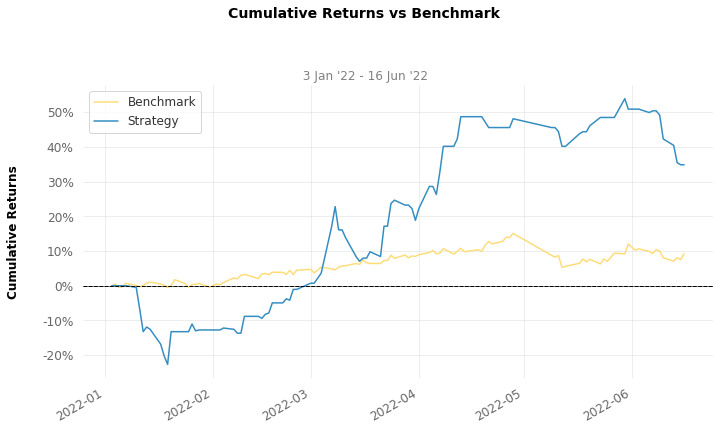

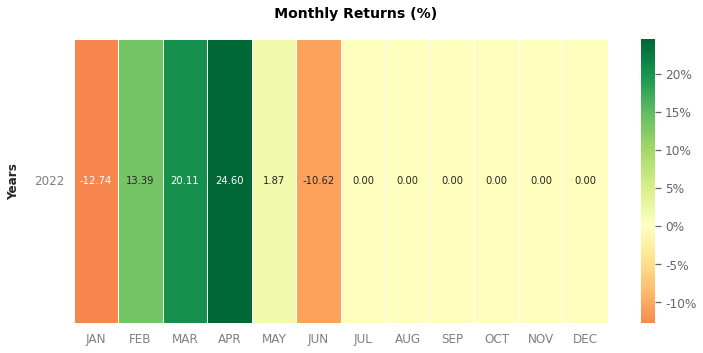

In [75]:
# Returns Visualization
i = 3
s_ret = s_ret_arr[i]

qs.plots.returns(s_ret, b_ret)
qs.plots.monthly_heatmap(s_ret)

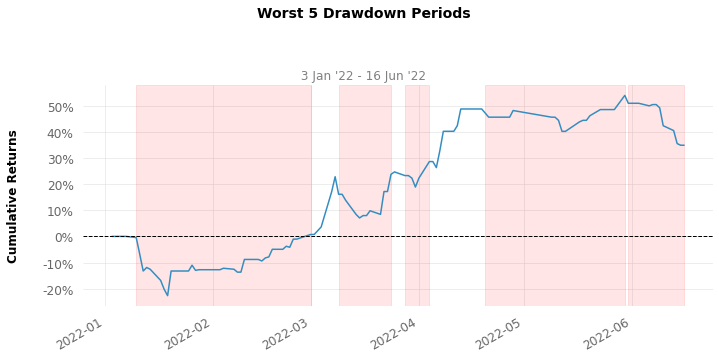

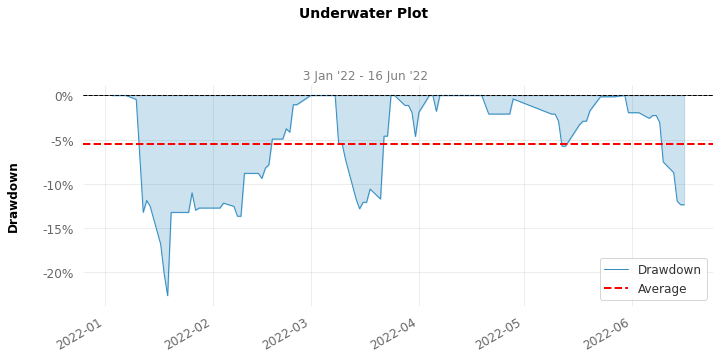

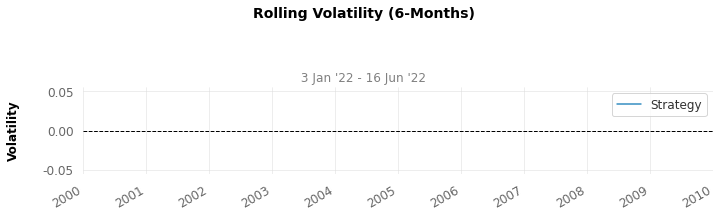

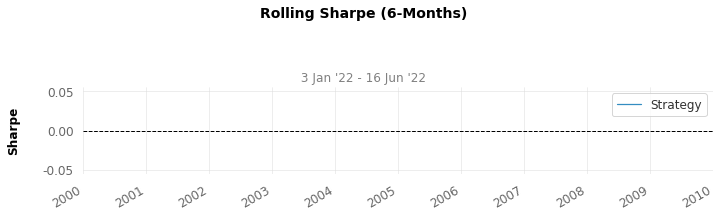

In [76]:
# Risk Visualization

qs.plots.drawdowns_periods(s_ret)
qs.plots.drawdown(s_ret)
qs.plots.rolling_volatility(s_ret)
qs.plots.rolling_sharpe(s_ret, rf=0.025)

### Additional Metrics

In [77]:
import scipy.stats as ss

# source: https://github.com/rubenbriones/Probabilistic-Sharpe-Ratio/blob/master/src/sharpe_ratio_stats.py
def prob_sr(ret, sr_benchmark=0):
    sr = qs.stats.sharpe(ret)
    n = len(ret)
    skew = ss.skew(ret)
    kurtosis = ss.kurtosis(ret, fisher=False)
    
    # Assuming SR is annualized, we need to change into periodical
    sr = sr/np.sqrt(252)
    sr_benchmark = sr_benchmark/np.sqrt(252)
    
    sr_std = np.sqrt((1 + (0.5 * sr ** 2) - (skew * sr) + (((kurtosis - 3) / 4) * sr ** 2)) / (n - 1))
    psr = ss.norm.cdf((sr - sr_benchmark) / sr_std)

    return psr

def expected_sr_max(trials_sr_std=0, num_trials=0, exp_sr_mean=0):
    emc = 0.5772156649
    max_z = (1 - emc) * ss.norm.ppf(1 - 1./num_trials) + emc * ss.norm.ppf(1 - 1./(num_trials * np.e))
    return exp_sr_mean + (trials_sr_std*max_z)

def def_sr(ret, trials_sr_df):
    sr_std = trials_sr_df.std()
    exp_sr_max = expected_sr_max(trials_sr_std=sr_std, num_trials=len(trials_sr_df))
    d_sr = prob_sr(ret, sr_benchmark=exp_sr_max)
    return d_sr

In [78]:
# Calculate Probabilistic and Deflated Sharpe Ratio
probabilistic_sr = prob_sr(s_ret_arr[i], sr_benchmark=0.025)

sr_std = pair_df['Sharpe'].std()
deflated_sr = def_sr(s_ret_arr[i], pair_df['Sharpe'])

print(probabilistic_sr)
print(deflated_sr)

0.8812883745898115
0.519527805528611


In [79]:
# source: https://sites.math.washington.edu/~morrow/336_20/papers20/lucius.pdf
def min_trl(ret, sr_benchmark=0, alpha=0.05):
    sr = qs.stats.sharpe(ret)
    skew = ss.skew(ret)
    kurtosis = ss.kurtosis(ret, fisher=False)
    
    trl = 1 + (1 - skew*sr + ((kurtosis - 1)/4) * sr**2) * (ss.norm.ppf(1-alpha) / (sr - sr_benchmark))**2
    
    return trl

In [80]:
# Calculate MinTRL (Min Track Record Length)

print(min_trl(s_ret_arr[3], sr_benchmark=2.8))

10.323646710051936


### Simulations

#### Combinatorial Purged Cross Validation

In [83]:
from timeseriescv.cross_validation import CombPurgedKFoldCV

# Generate Split Index
cv = CombPurgedKFoldCV(n_splits=8, n_test_splits=7)
split_idxs = list(cv.split(lq45_out_df['LQ45']['Adj Close'], pred_times=lq45_out_df['LQ45']['Date'], eval_times=lq45_out_df['LQ45']['Date']))

print(f"Length of One Split: {len(split_idxs[0][0])}")
print(f"Total Test Data    : {sum([len(split_idxs[n][1]) for n in range(len(split_idxs))])}")

Length of One Split: 14
Total Test Data    : 742


In [92]:
# Run CPCV on All Pairs
pair_df_cv = {}
pair_df_cv['ticker_1'] = []
pair_df_cv['ticker_2'] = []
pair_df_cv['Returns Mean (Ann)'] = []
pair_df_cv['Returns Volatility (Ann)'] = []
pair_df_cv['Sharpe'] = []
pair_df_cv['Prob. Sharpe'] = []
pair_df_cv['#Trades'] = []
pair_df_cv['#Trades (Ann)'] = []

s_ret_cv_pairs = []
for i, pair in tqdm(enumerate(coint_pairs)):
    s_ret_cv_arr = []
    s_df_cv_arr = []
    for split_idx in split_idxs:
        train_idx, test_idx = split_idx

        S1 = lq45_out_df[pair[0]]['Adj Close'].iloc[train_idx]
        S2 = lq45_out_df[pair[1]]['Adj Close'].iloc[train_idx]
        b = calc_beta(S1, S2)

        hl = pair_df['half_life'][i]

        buff_dict = {}
        buff_dict[pair[0]] = lq45_out_df[pair[0]].iloc[test_idx].reset_index()
        buff_dict[pair[1]] = lq45_out_df[pair[1]].iloc[test_idx].reset_index()

        s_df = strategy(buff_dict, pair, round(hl), beta=b)
        s_df = calc_returns_strategy(s_df)
        s_ret = s_df.set_index('Date')['return']

        s_ret_cv_arr.append(s_ret)
        s_df_cv_arr.append(s_df)
    s_ret_cv = pd.concat(s_ret_cv_arr)
    s_df_cv = pd.concat(s_df_cv_arr)
    s_ret_cv_pairs.append(s_ret_cv)
    
    pair_df_cv['ticker_1'].append(pair[0])
    pair_df_cv['ticker_2'].append(pair[1])
    pair_df_cv['Returns Mean (Ann)'].append(s_ret_cv.mean() * 252)
    pair_df_cv['Returns Volatility (Ann)'].append(s_ret_cv.std() * np.sqrt(252))
    pair_df_cv['Sharpe'].append(qs.stats.sharpe(s_ret_cv))
    pair_df_cv['Prob. Sharpe'].append(prob_sr(s_ret_cv, sr_benchmark=0.025))
    
    entry_trades = len(s_df_cv[s_df_cv['signal'] == 'long_entry']) + len(s_df_cv[s_df_cv['signal'] == 'short_entry'])
    close_trades = len(s_df_cv[s_df_cv['signal'] == 'long_close']) + len(s_df_cv[s_df_cv['signal'] == 'short_close'])
    pair_df_cv['#Trades'].append(min([entry_trades, close_trades]))
    
    pair_df_cv['#Trades (Ann)'].append(min([entry_trades, close_trades]) / (len(s_ret_cv) / 252))

# Calculate Deflated Sharpe
pair_df_cv['Deflated Sharpe'] = []

for s_ret_cv in s_ret_cv_pairs:
    pair_df_cv['Deflated Sharpe'].append(def_sr(s_ret_cv, 
                                                pd.DataFrame(pair_df_cv['Sharpe'], columns=['Sharpe']))[0])

# Display Metrics Dataframe
pair_df_cv = pd.DataFrame(pair_df_cv)   
display(pair_df_cv)

14it [00:07,  1.81it/s]


,ticker_1,ticker_2,Returns Mean (Ann),Returns Volatility (Ann),Sharpe,Prob. Sharpe,#Trades,#Trades (Ann),Deflated Sharpe
0,HRUM.JK,ADRO.JK,0.215151,0.545143,0.394670,0.738652,67,22.754717,0.069932
1,PGAS.JK,LQ45,0.052976,0.151873,0.348818,0.708737,116,39.396226,0.063355
2,TPIA.JK,ITMG.JK,0.635704,0.319992,1.986622,0.999233,45,15.283019,0.883401
3,INCO.JK,ANTM.JK,0.703520,0.474294,1.483300,0.995892,133,45.169811,0.664808
4,AMRT.JK,UNVR.JK,-0.020737,0.339678,-0.061048,0.441346,67,22.754717,0.012365
5,CPIN.JK,JPFA.JK,0.177888,0.271347,0.655574,0.862798,118,40.075472,0.152054
6,ICBP.JK,LQ45,-0.055073,0.222420,-0.247607,0.319958,89,30.226415,0.005124
7,BBNI.JK,BMRI.JK,0.453834,0.247630,1.832711,0.999173,108,36.679245,0.845386
8,BBRI.JK,BBTN.JK,0.140878,0.315218,0.446922,0.768568,114,38.716981,0.081556
9,GGRM.JK,HMSP.JK,0.001252,0.122103,0.010257,0.489917,16,5.433962,0.016885


#### Monte Carlo
Source: https://github.com/Rachnog/Advanced-Deep-Trading/blob/master/proba_backtest/Stochastic%20Simulations.ipynb

Price series are generated by: (1) Modeling Close data using Monte Carlo (2) Predicting other related parameters using machine learning.

For our specific sake, we only need the close data, so we do not need to use machine learning to generate the other parameters

In [98]:
import math
import random

def convert_to_returns(log_returns):
    """
    This method exponentiates a sequence of log returns to get daily returns.
    """
    return np.exp(log_returns)

def convert_to_prices(log_returns, s0 = 1e-3):
    """
    This method converts a sequence of log returns into normal returns (exponentiation) and then computes a price
    sequence given a starting price, param.all_s0.
    """
    returns = convert_to_returns(log_returns)
    price_sequence = [s0]
    for i in range(1, len(returns)):
        price_sequence.append(price_sequence[i - 1] * returns[i - 1])
    return np.array(price_sequence)


# Stochastic Processes
def brownian_motion_log_returns(delta, sigma, N):
    """
    This method returns a Wiener process. The Wiener process is also called Brownian motion. For more information
    about the Wiener process check out the Wikipedia page: http://en.wikipedia.org/wiki/Wiener_process
    """
    sqrt_delta_sigma = math.sqrt(delta) * sigma
    return np.random.normal(loc=0, scale=sqrt_delta_sigma, size=N)

def geometric_brownian_motion_log_returns(delta, mu, sigma, N):
    """
    This method constructs a sequence of log returns which, when exponentiated, produce a random Geometric Brownian
    Motion (GBM). GBM is the stochastic process underlying the Black Scholes options pricing formula.
    """
    wiener_process = np.array(brownian_motion_log_returns(delta, sigma, N))
    sigma_pow_mu_delta = (mu - 0.5 * math.pow(sigma, 2.0)) * delta
    return wiener_process + sigma_pow_mu_delta

def jump_diffusion_process(delta, lamda, jumps_mu, jumps_sigma, N):
    """
    This method produces a sequence of Jump Sizes which represent a jump diffusion process. These jumps are combined
    with a geometric brownian motion (log returns) to produce the Merton model.
    """
    s_n = time = 0
    small_lamda = -(1.0 / lamda)
    jump_sizes = []
    for k in range(0, N):
        jump_sizes.append(0.0)
    while s_n < N:
        s_n += small_lamda * math.log(np.random.uniform(0, 1))
        for j in range(0, N):
            if time * delta <= s_n * delta <= (j + 1) * delta:
                # print("was true")
                jump_sizes[j] += random.normalvariate(jumps_mu, jumps_sigma)
                break
        time += 1
    return jump_sizes

def geometric_brownian_motion_jump_diffusion_log_returns(delta, mu, sigma, lamda, jumps_mu, jumps_sigma, N):
    """
    This method constructs combines a geometric brownian motion process (log returns) with a jump diffusion process
    (log returns) to produce a sequence of gbm jump returns.
    """
    jump_diffusion = jump_diffusion_process(delta, lamda, jumps_mu, jumps_sigma, N)
    geometric_brownian_motion = geometric_brownian_motion_log_returns(delta, mu, sigma, N)
    return np.add(jump_diffusion, geometric_brownian_motion)

In [153]:
pair = coint_pairs[3]
ticker = pair[0]
price_mean, price_std = lq45_out_df[ticker]['Adj Close'].pct_change().mean(), lq45_out_df[ticker]['Adj Close'].pct_change().std()

x = geometric_brownian_motion_jump_diffusion_log_returns(1, price_mean, price_std, 0.1, -0.01, 0.001, 100)

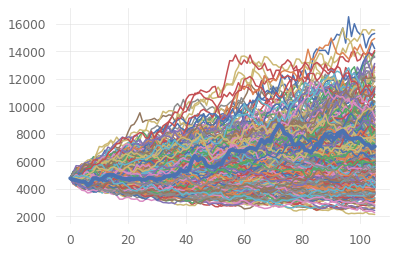

In [157]:
# Create N Price Curves
N = 500
start_price = lq45_out_df[ticker]['Adj Close'][0]
for i in range(N):
    x = geometric_brownian_motion_jump_diffusion_log_returns(1, price_mean, price_std, 0.1, -0.01, 0.001, len(lq45_out_df[ticker]))
    plt.plot(convert_to_prices(x, start_price))
plt.plot(lq45_out_df[ticker]['Adj Close'], linewidth=4)

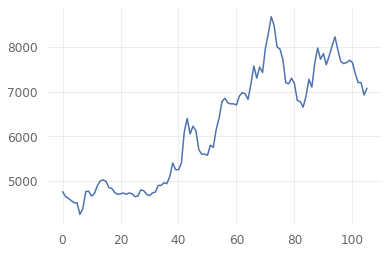

In [158]:
plt.plot(lq45_out_df[ticker]['Adj Close'])